# Find non-advective edges in bathymetry

See https://github.com/OceansAus/access-om2/issues/99
and https://github.com/COSIMA/access-om2/issues/210

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import netCDF4 as nc
import IPython.display

In [2]:
Cgrid = '/g/data/x77/aek156/make_OM3_025deg_topo/topography_intermediate_output/topog_new_fillfraction_edited_deseas.nc'
Bgrid = '/g/data/x77/aek156/make_OM3_025deg_topo/topography_intermediate_output/topog_new_fillfraction_B_edited_fixnonadvective_deseas.nc'
merged = '/g/data/x77/aek156/make_OM3_025deg_topo/topography_intermediate_output/topog_new_fillfraction_merged.nc'
merged_post_edit = '/g/data/x77/aek156/make_OM3_025deg_topo/topography_intermediate_output/topog_new_fillfraction_merged_edited_deseas.nc'
Cgridfinal='/g/data/x77/aek156/make_OM3_025deg_topo/topography_intermediate_output/topog_new_fillfraction_edited_deseas_mindepth.nc'
final = '/g/data/x77/aek156/make_OM3_025deg_topo/topog.nc'

bathyfile = Bgrid
depth = nc.Dataset(bathyfile).variables['depth'][:,:]

jsize, isize = np.shape(depth)

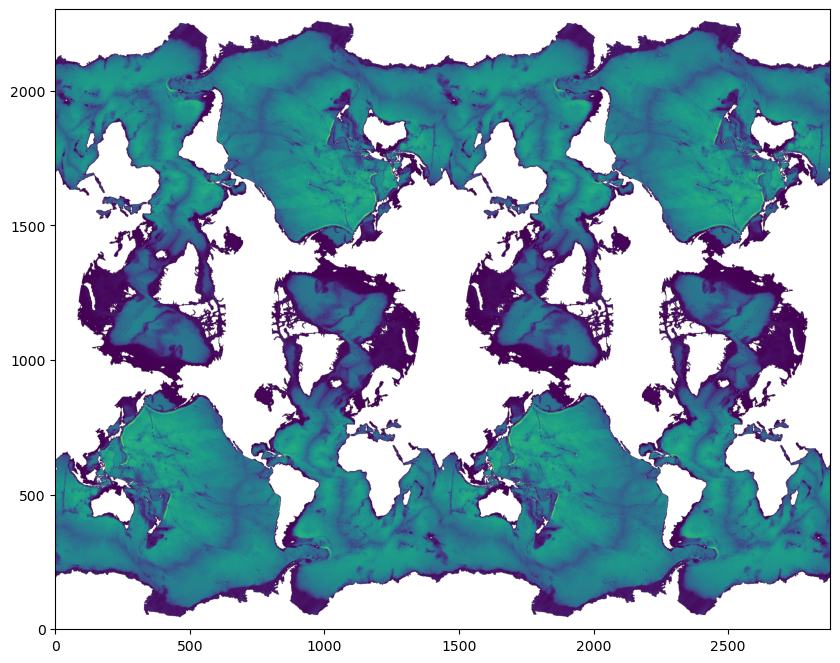

In [3]:
# make tiled version for plotting across joins
depthtiled = np.zeros((2*jsize,2*isize))
depthtiled[:jsize, :isize] = depth
# add flipped copy along tripole seam
depthtiled[jsize:, 0:int(isize/2)] = np.flip(np.flip(depth[:jsize,int(isize/2):isize],0),1)
depthtiled[jsize:, int(isize/2):isize] = np.flip(np.flip(depth[:jsize,0:int(isize/2)],0),1)
# add zonal repeat
depthtiled[:, isize:] = depthtiled[:, :isize] 
# velzero[-1,int(isize/2):-1] = np.flip(velzero[-2,0:int(isize/2)], 0)
depthtiled = np.ma.masked_less_equal(depthtiled, 0)

plt.figure(figsize=(10,10))
plt.imshow(depthtiled, origin='lower')

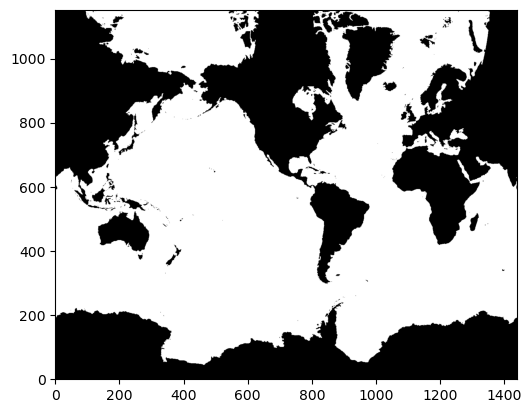

In [4]:
landmask = np.zeros((jsize+1,isize+1),dtype=int)
if True: #not np.ma.is_masked(depth):
    depth = np.ma.masked_less_equal(depth, 0)
landmask[:-1, :-1] = np.ma.getmask(depth).astype(int) 
# add copied points along tripole seam
landmask[-1, 0:int(isize/2)] = np.flip(landmask[-2,int(isize/2):-1],0)
landmask[-1,int(isize/2):-1] = np.flip(landmask[-2,0:int(isize/2)], 0)
# add LH edge to RH edge
landmask[:, -1] = landmask[:, 0]
plt.figure
plt.imshow(landmask, origin='lower', cmap=cm.binary)

In [5]:
velzero = np.zeros(np.shape(landmask), dtype=bool)  # whether u,v are zero on NE corner of cell
velzero[:-1, :-1] = landmask[:-1, :-1]+landmask[1:, :-1]+landmask[:-1, 1:]+landmask[1:, 1:] > 0 # true if velocity point touches land mask
# add copied points along tripole seam
velzero[-1,  0:int(isize/2)] = np.flip(velzero[-2, int(isize/2):-1],0)
velzero[-1, int(isize/2):-1] = np.flip(velzero[-2, 0:int(isize/2)], 0)
# add LH edge to RH edge
velzero[:, -1] = velzero[:, 0]

# plt.imshow(velzero, origin='lower', cmap=cm.binary)

In [6]:
# now find ocean cells that have zero flux through either open northern or open eastern edges
# see fig 9.4 in Griffies2012a-mom-elements-5-updated.pdf
noadvN = np.zeros(np.shape(landmask),dtype=bool)
noadvE = np.zeros(np.shape(landmask), dtype=bool)

noadvN[:, 1:] = np.logical_and(velzero[:, 1:], velzero[:, :-1])  # no flux through northern edge
noadvN[:, 0 ] = noadvN[:, -1]  # copy RH edge to LH edge
noadvN[:-1, :] = np.logical_and(noadvN[:-1, :], np.logical_not(landmask[1:, :]))  # only consider open northern edges

noadvE[1:, :] = np.logical_and(velzero[1:, :], velzero[:-1, :])  # no flux through eastern edge
noadvE[0 , :] = velzero[1, :]  # assumes no flow along southern edge
noadvE[:, :-1] = np.logical_and(noadvE[:, :-1], np.logical_not(landmask[:, 1:]))  # only consider open eastern edges

noadv_edge = np.logical_or(noadvN[:-1, :-1], noadvE[:-1, :-1])
noadv_edge = np.logical_and(noadv_edge, np.logical_not(landmask[:-1, :-1]))  # only consider ocean points

# find cells with no advection through any edge
noadv_cell = np.zeros(np.shape(landmask), dtype=bool)
noadv_cell[1:, 1:] = np.logical_and(np.logical_and(np.logical_and(velzero[1:, 1:], velzero[1:, :-1]), velzero[:-1, 1:]), velzero[:-1, :-1])
noadv_cell[0, 1:] = np.logical_and(velzero[0, 1:], velzero[0, :-1]) # assumes no flow along southern edge
noadv_cell[:, 0] = noadv_cell[:, -1]  # copy RH edge to LH edge
noadv_cell = noadv_cell[:-1, :-1]
noadv_cell = np.logical_and(noadv_cell, np.logical_not(landmask[:-1, :-1]))  # only consider ocean points

In [7]:
np.count_nonzero(noadv_cell)

0

In [8]:
np.count_nonzero(noadv_edge)

43

In [9]:
margin = 20
jj, ii=np.nonzero(noadv_cell)
print ('cells with no advective edges: '+repr(list(zip(ii+1, jj+1))))
for k in range(len(ii)):
    i = ii[k]
    j = jj[k]
    plt.figure(figsize=(5, 5))
    plt.imshow(depthtiled, vmin=0, vmax=200, origin='lower')
    plt.colorbar()
    plt.scatter(i, j, facecolors='none', edgecolors='r')
    plt.xlim(i-margin, i+margin)
    plt.ylim(j-margin, j+margin)
    plt.title('Non-advective cell: MOM index '+str(i+1)+', '+str(j+1)+'\n'+bathyfile)
    plt.xlabel('i (indexed from 0)')
    plt.ylabel('j (indexed from 0)')
    figfname = 'non-advective/non_advective_cell'+bathyfile.replace('/', '_').replace('.', '_')+'_'+str(i+1)+'_'+str(j+1)+'.png'
#     plt.savefig(figfname, dpi=100, bbox_inches="tight")

cells with no advective edges: []


cells with a non-advective edge: [(1315, 204), (881, 220), (876, 242), (353, 355), (372, 419), (349, 503), (432, 511), (180, 533), (308, 535), (316, 535), (299, 545), (290, 550), (287, 554), (193, 575), (65, 577), (155, 607), (179, 607), (182, 608), (51, 616), (874, 631), (1065, 687), (235, 730), (1219, 731), (1215, 743), (274, 770), (897, 807), (804, 810), (425, 812), (477, 834), (531, 870), (533, 871), (824, 890), (1173, 944), (1086, 969), (1049, 1012), (903, 1081), (1222, 1098), (186, 1108), (1230, 1109), (149, 1126), (107, 1127), (876, 1141), (565, 1150)]


/jobfs/159781430.gadi-pbs/ipykernel_194435/2424111179.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 5))


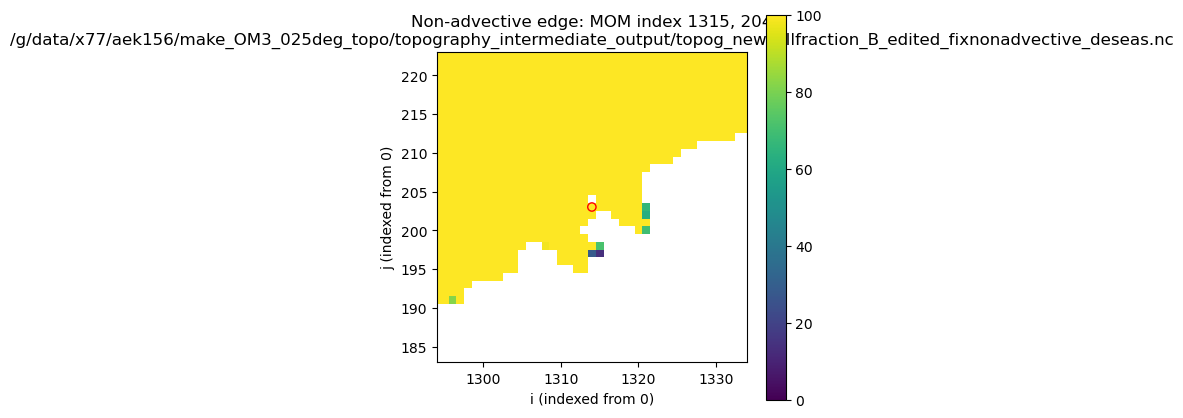

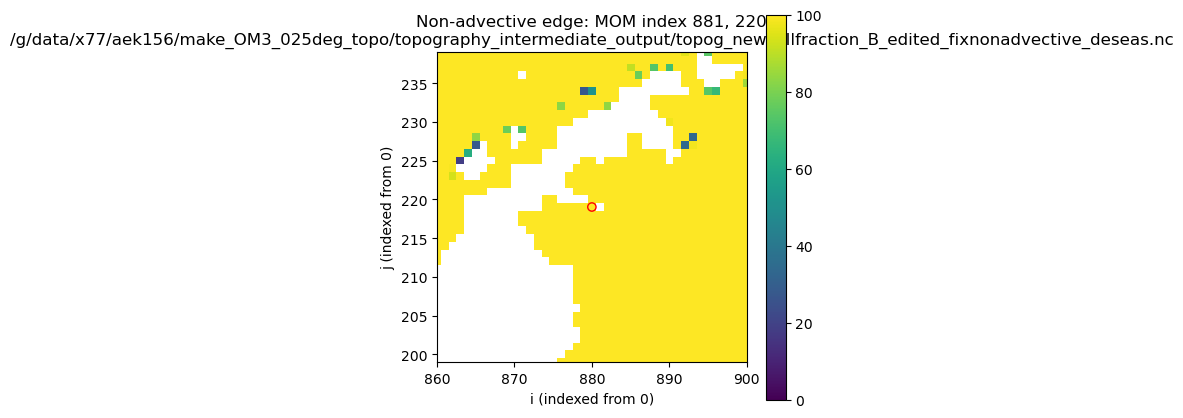

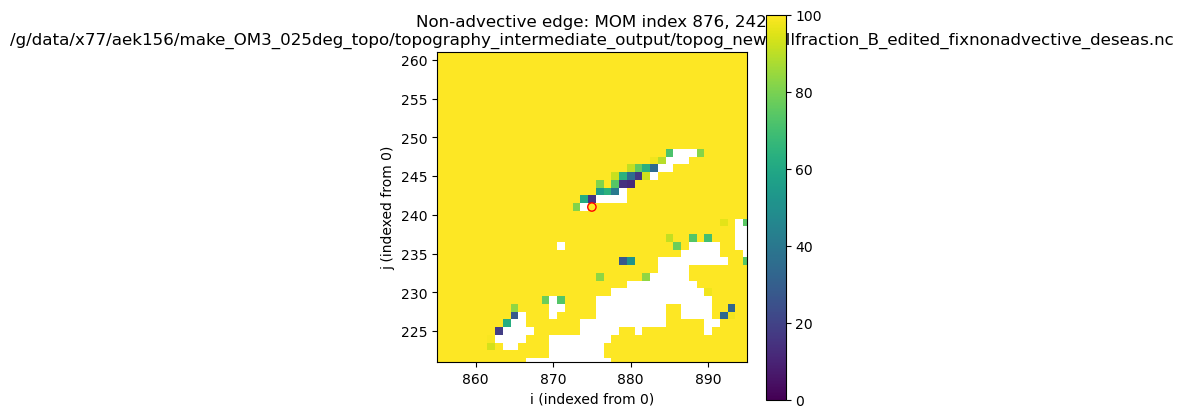

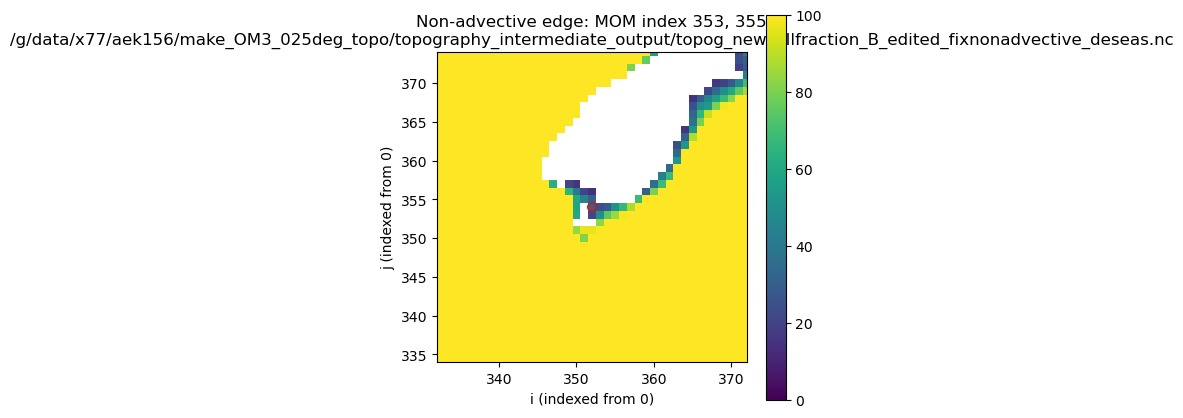

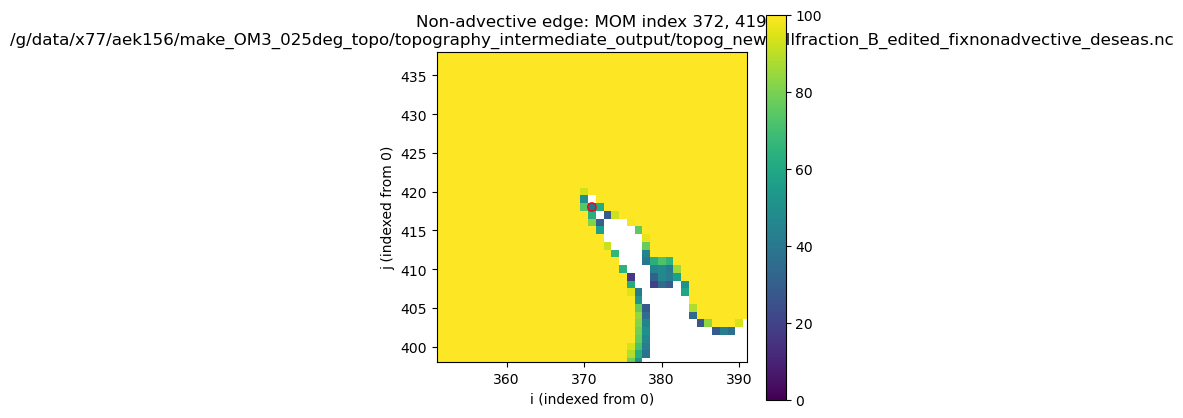

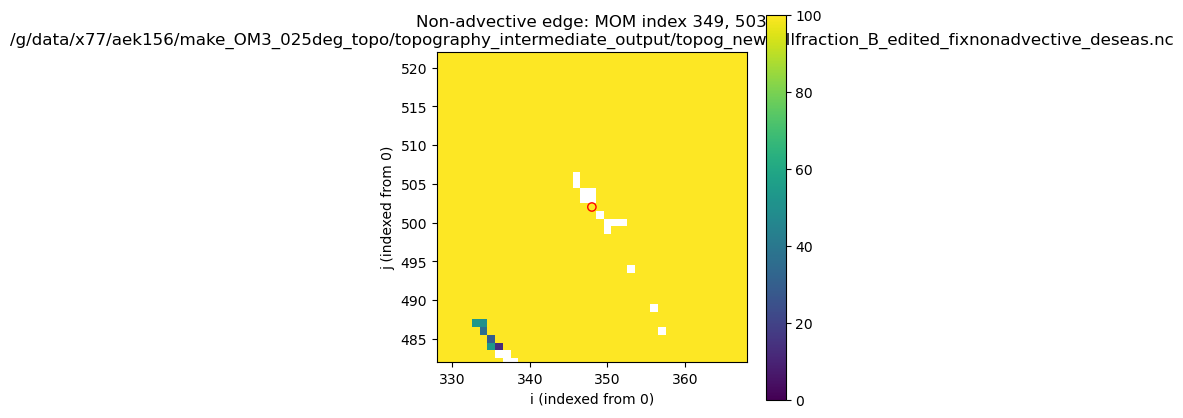

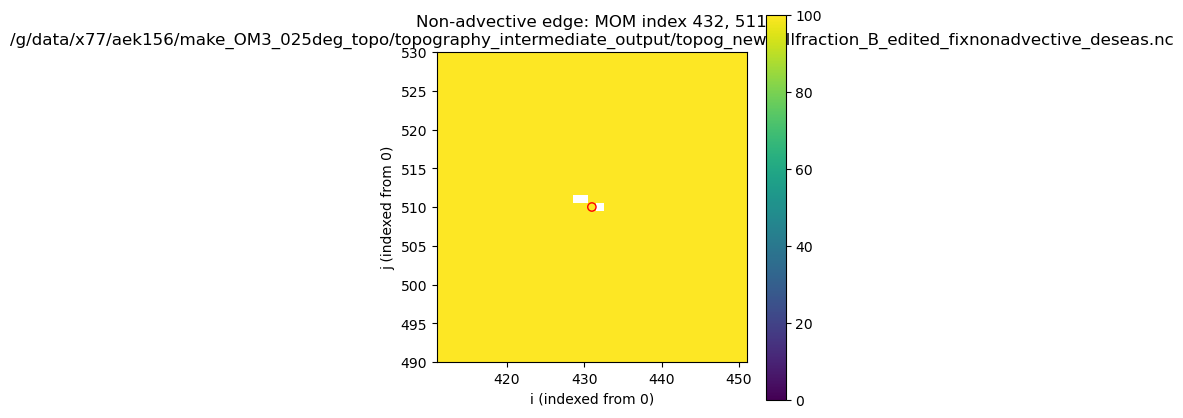

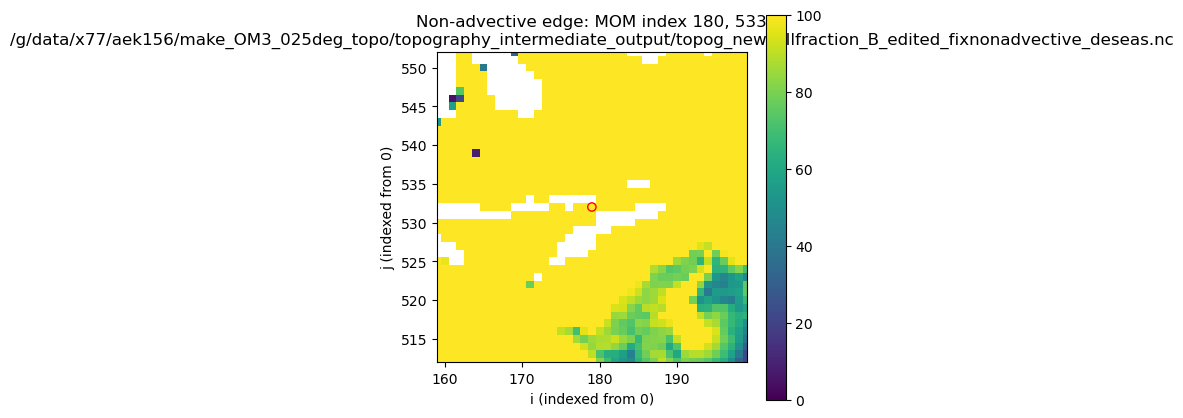

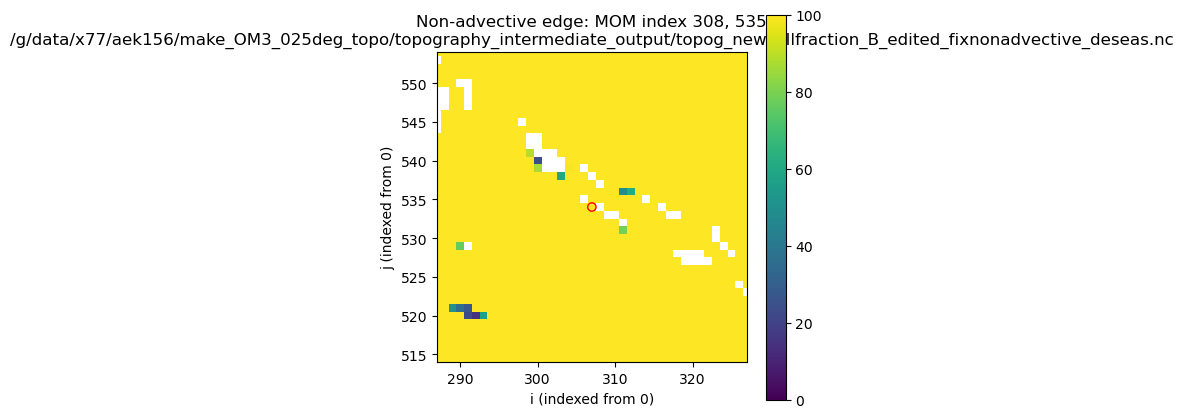

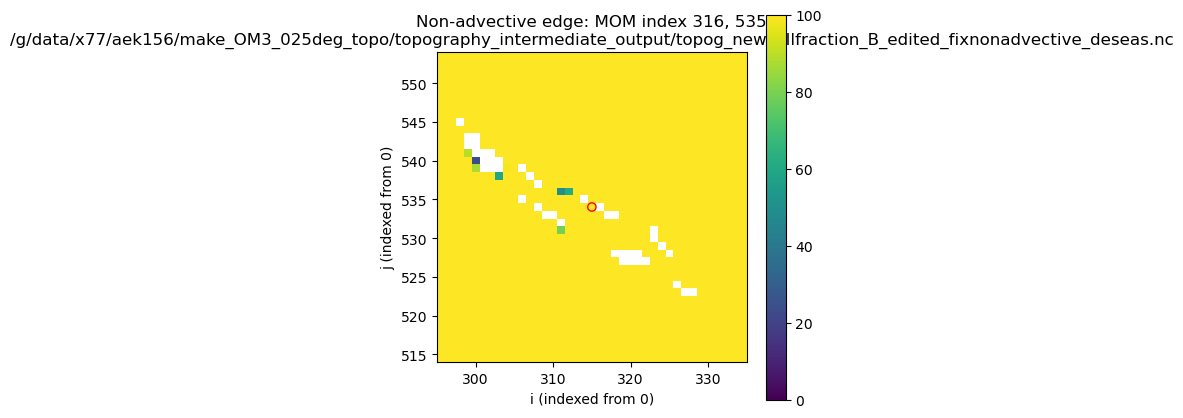

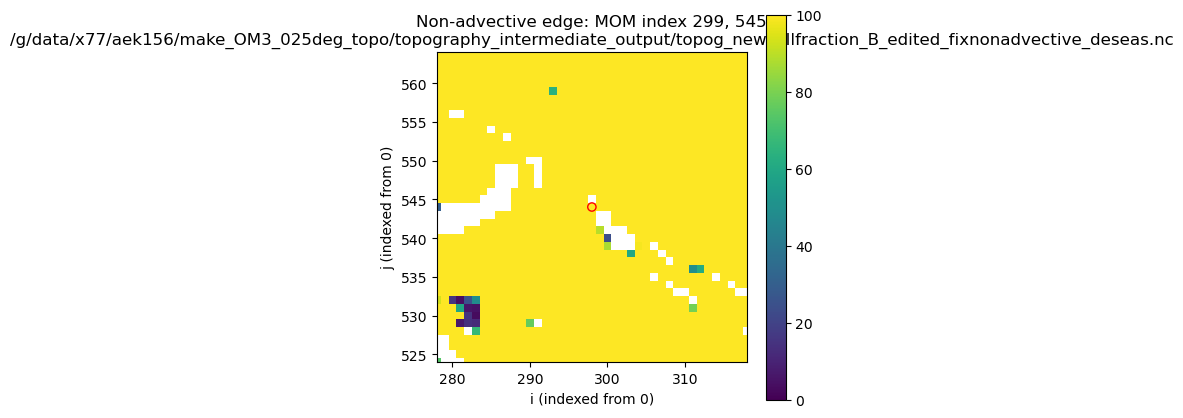

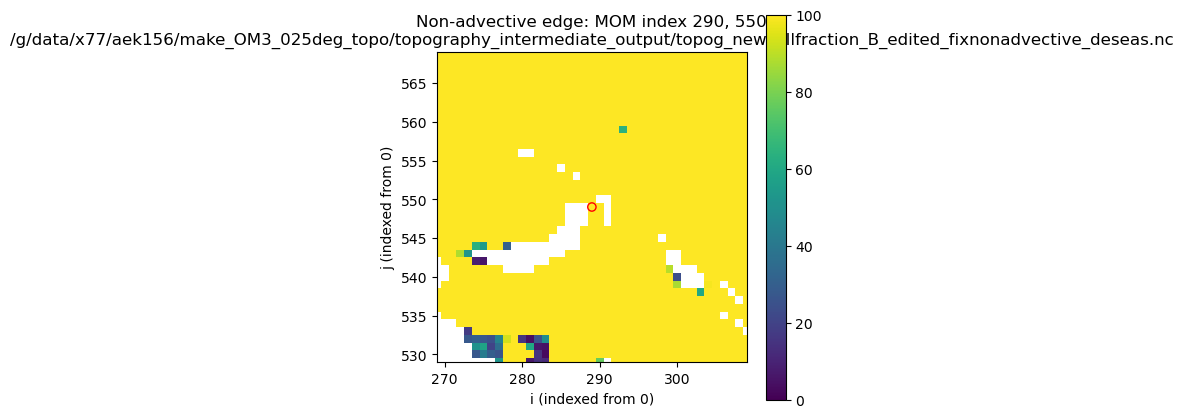

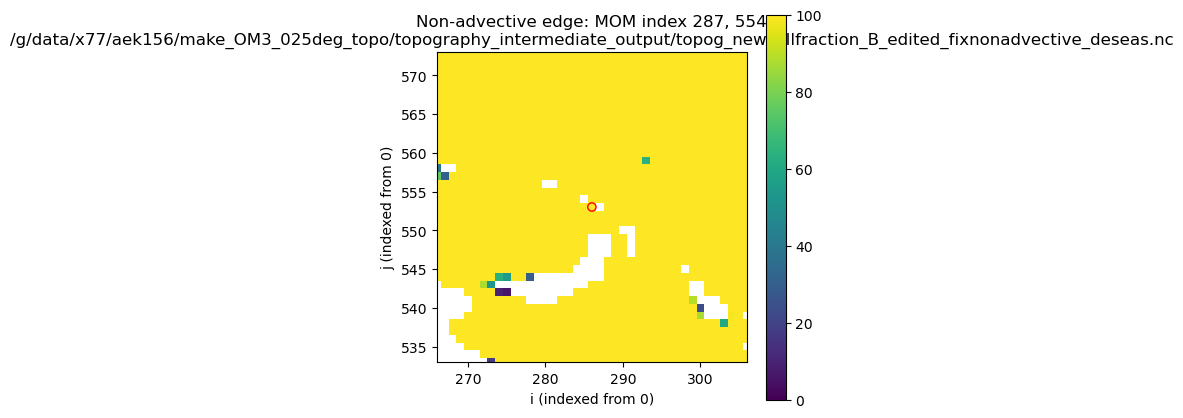

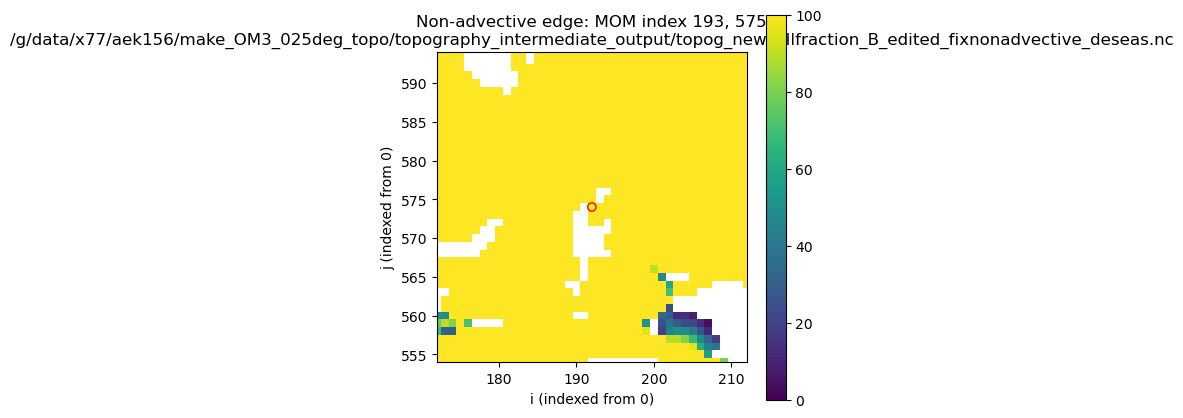

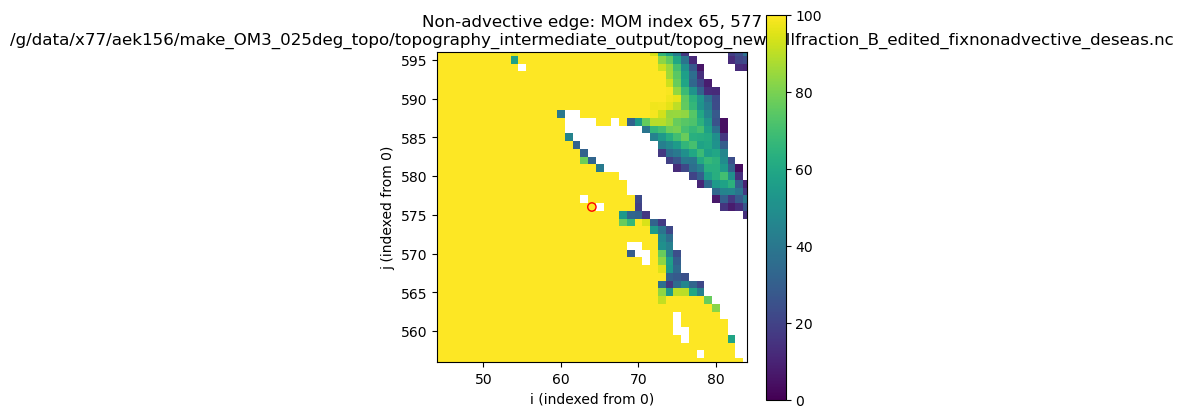

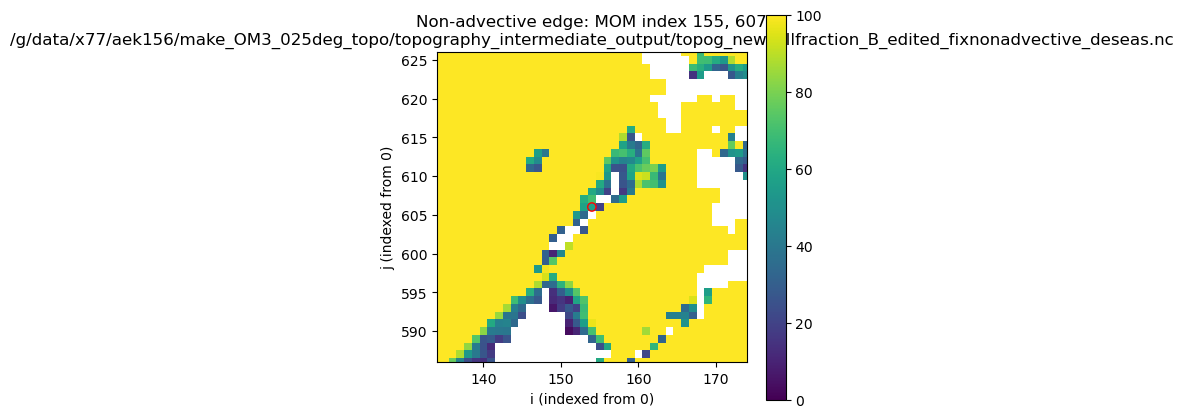

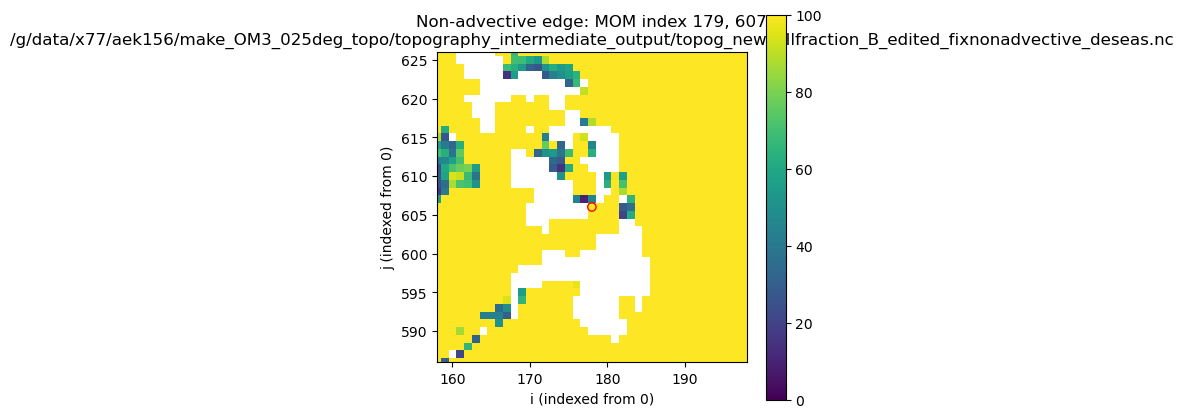

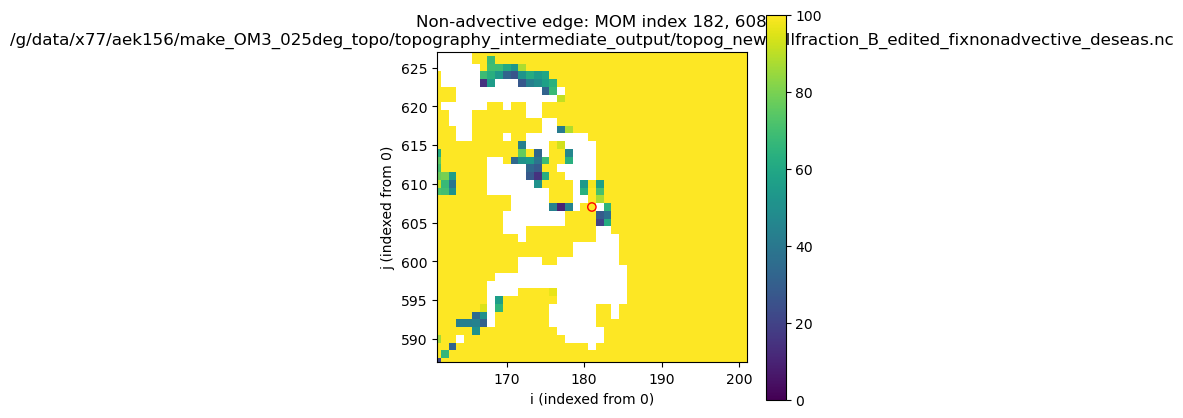

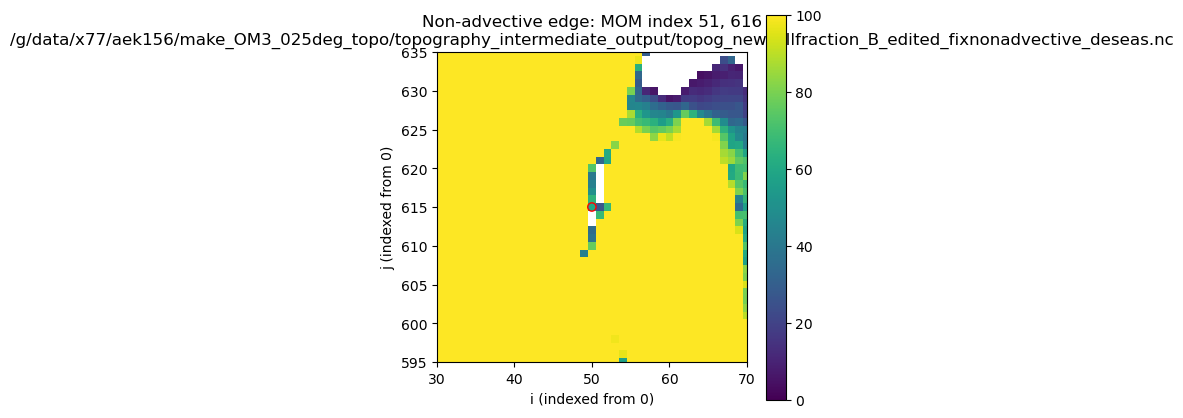

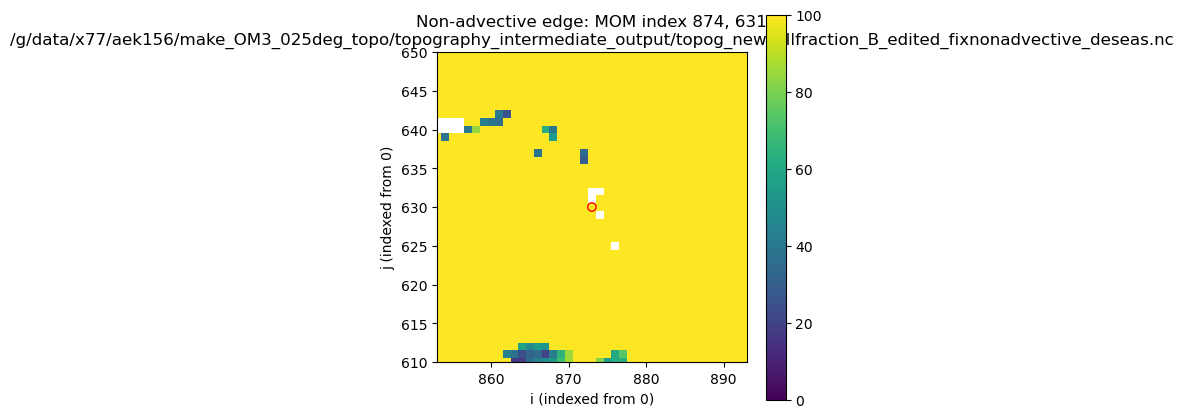

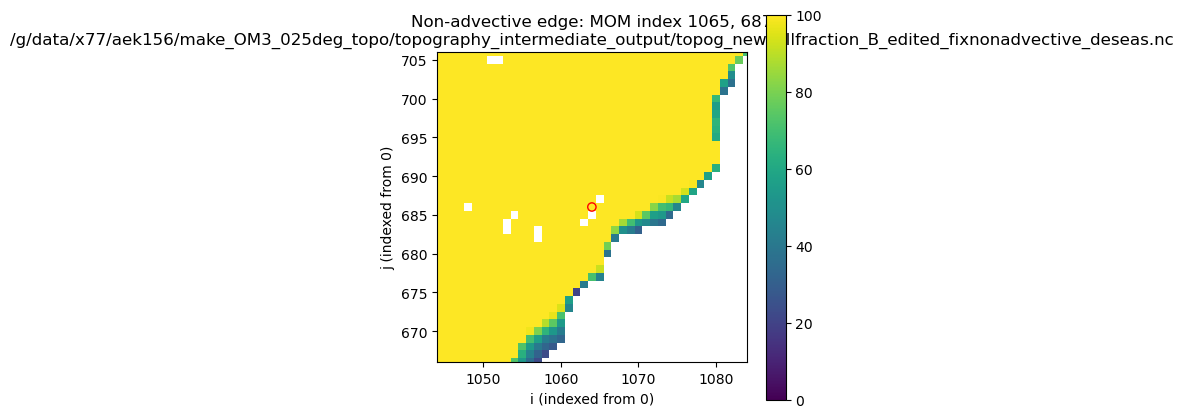

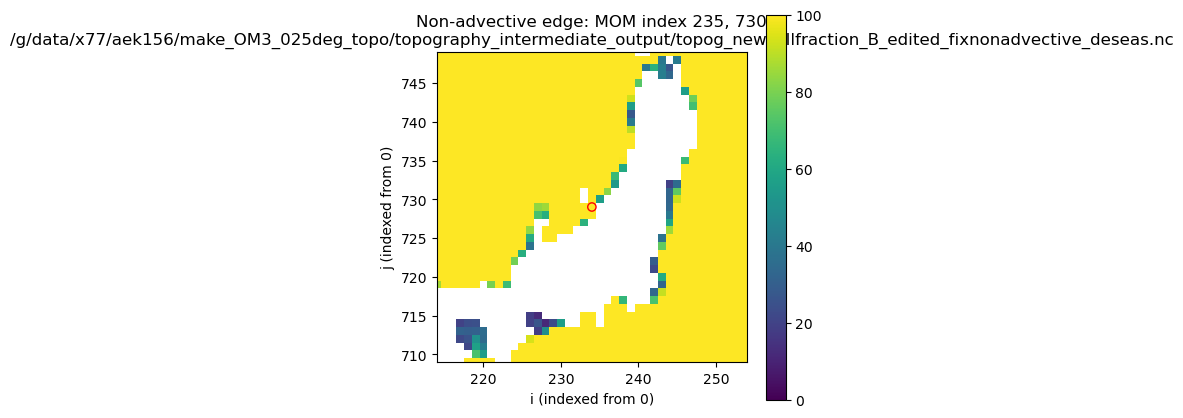

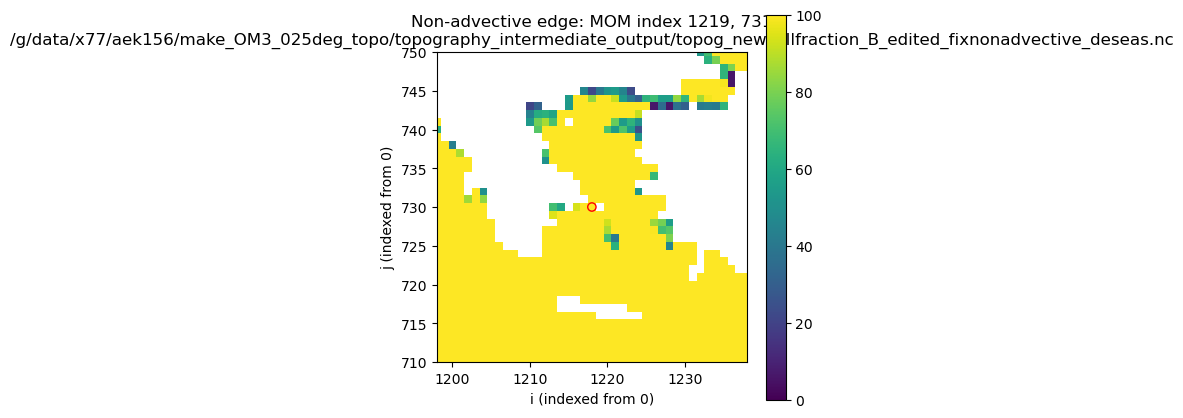

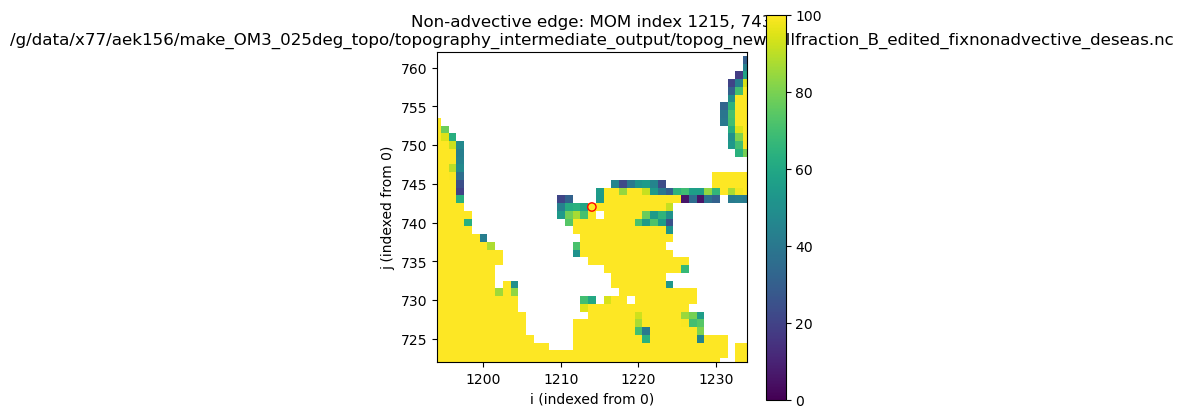

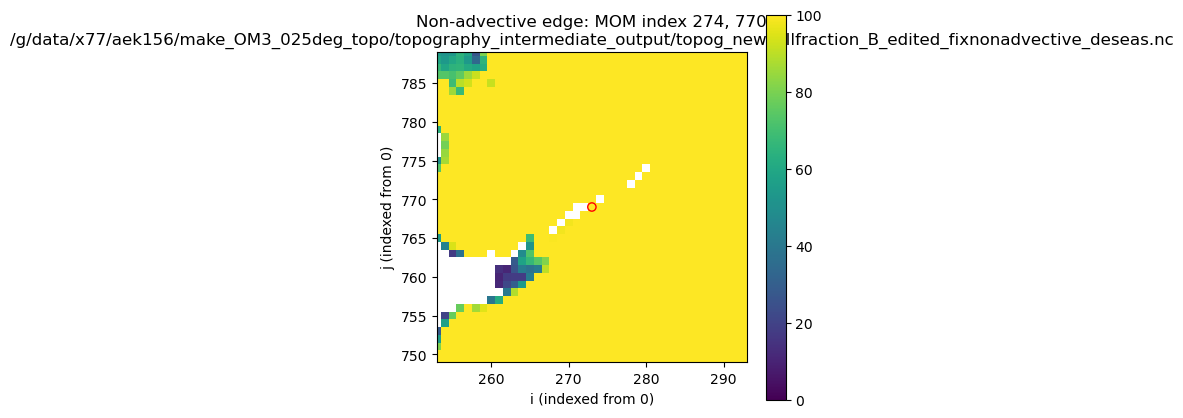

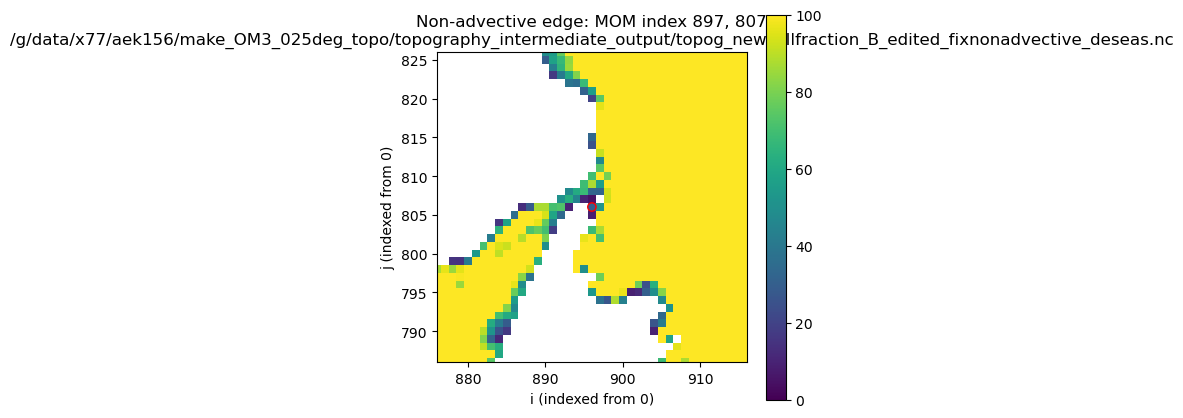

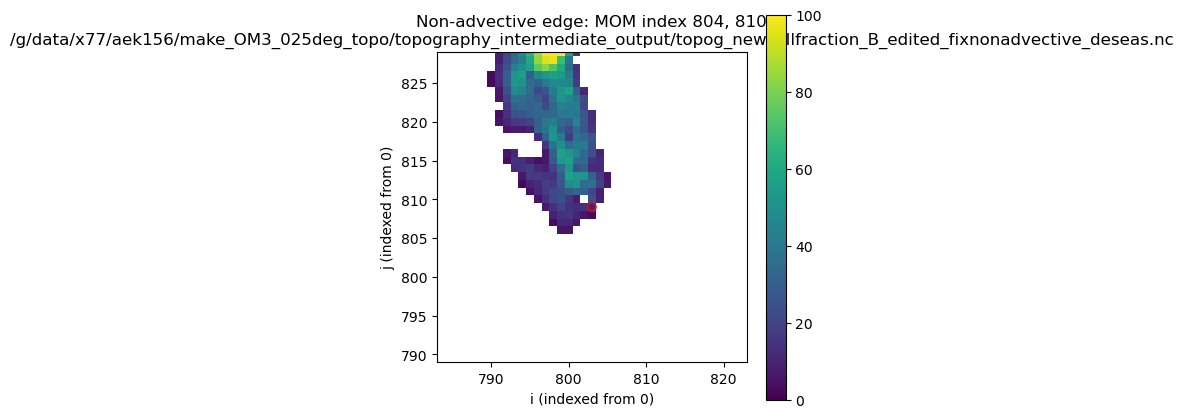

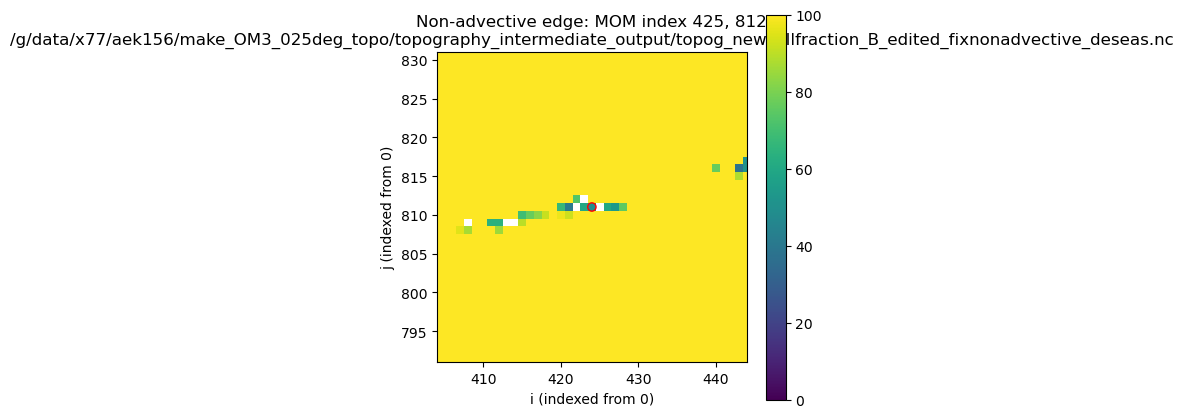

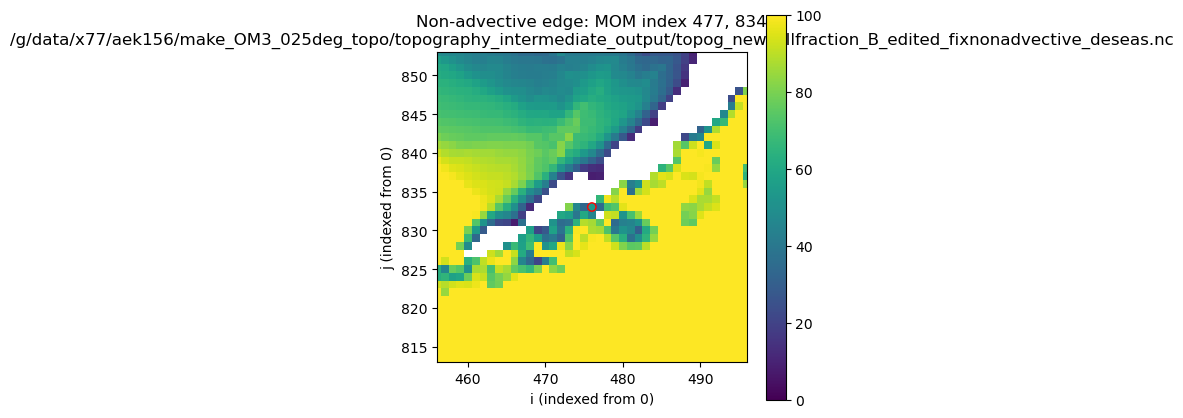

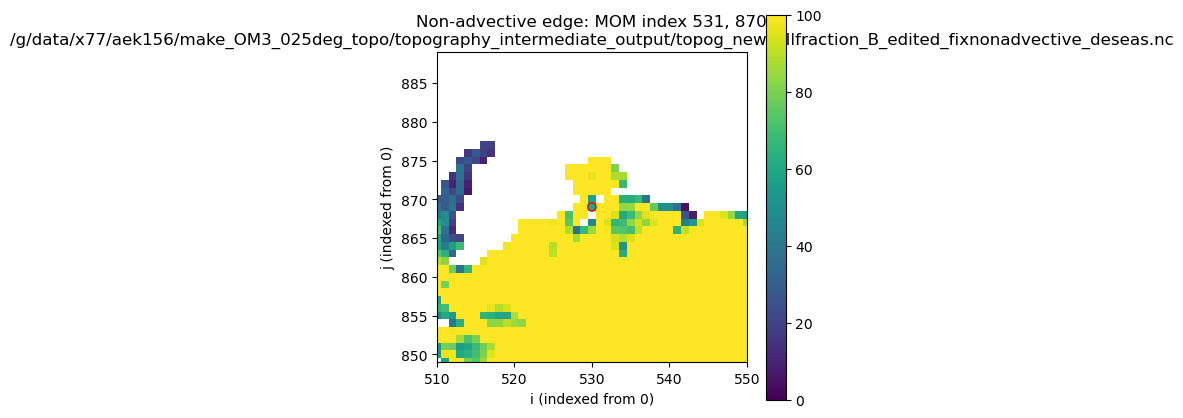

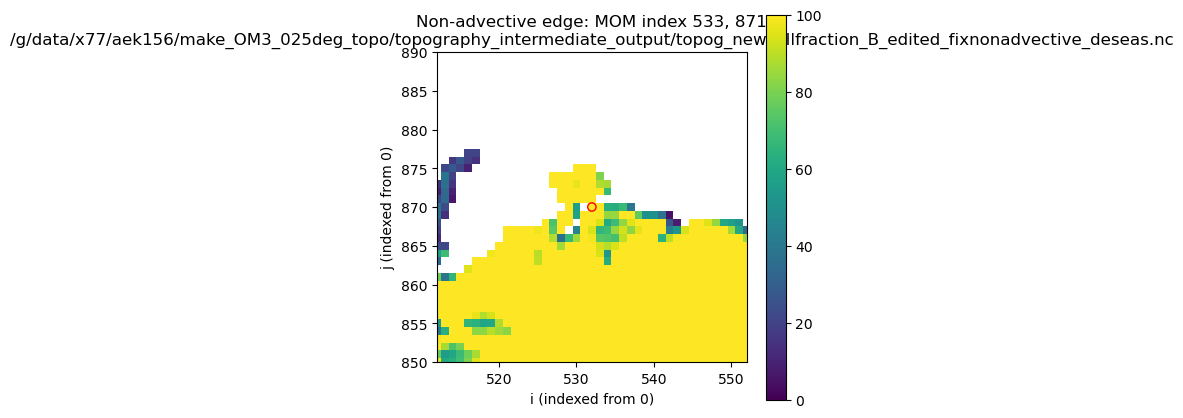

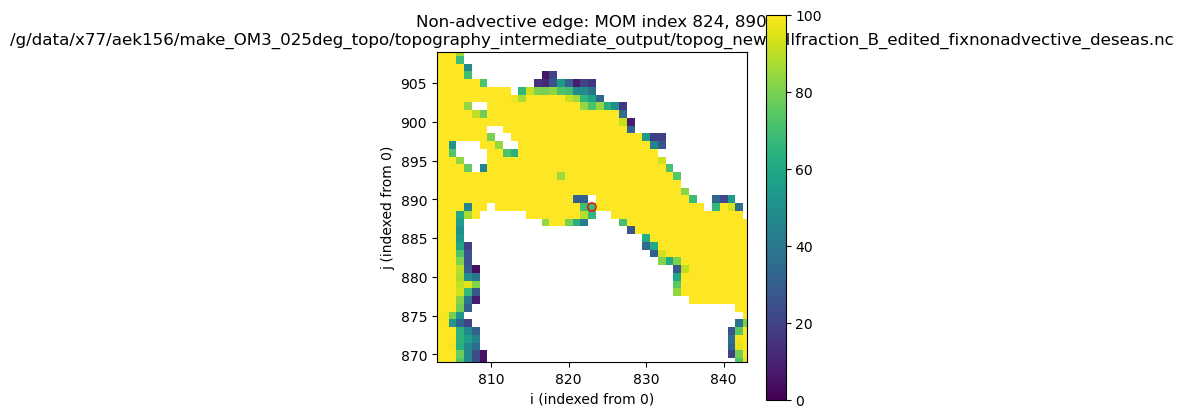

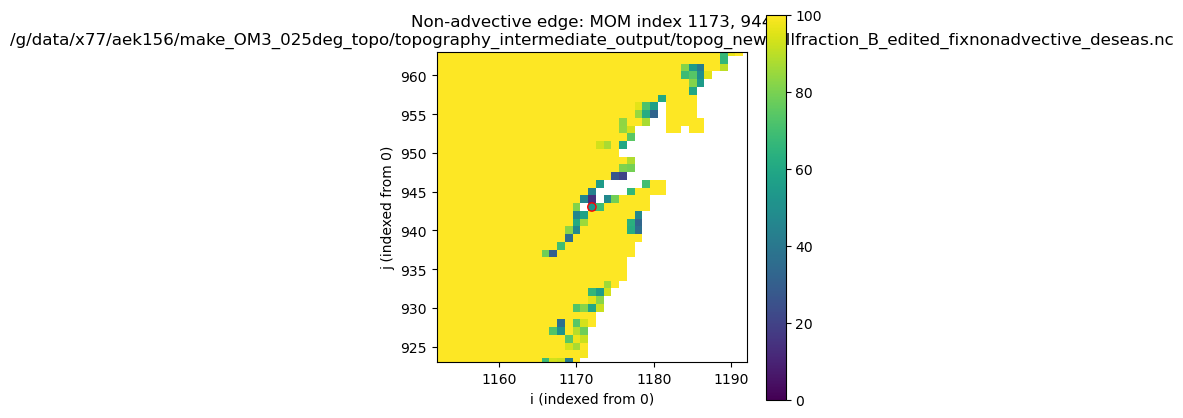

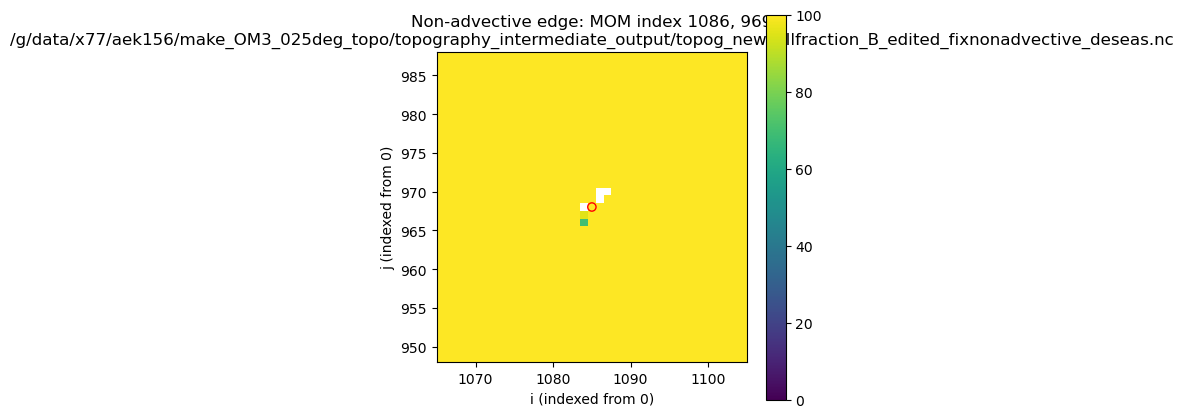

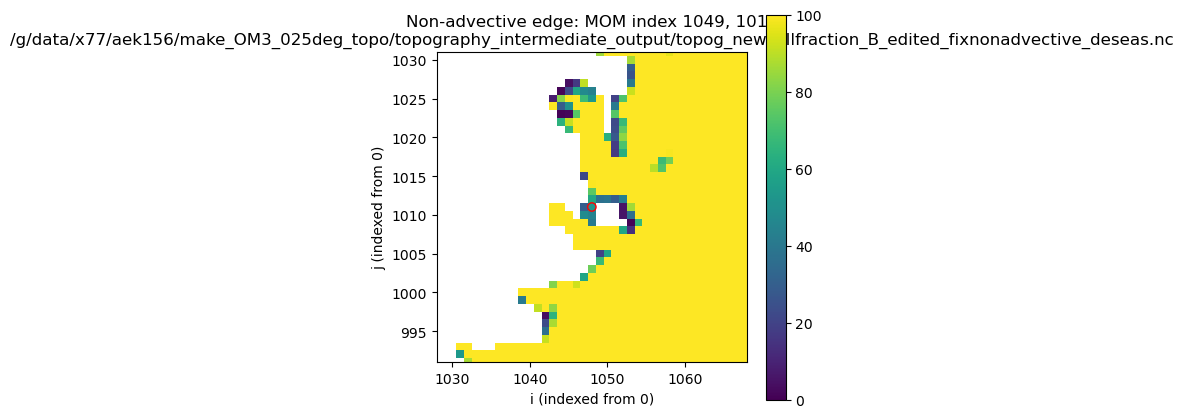

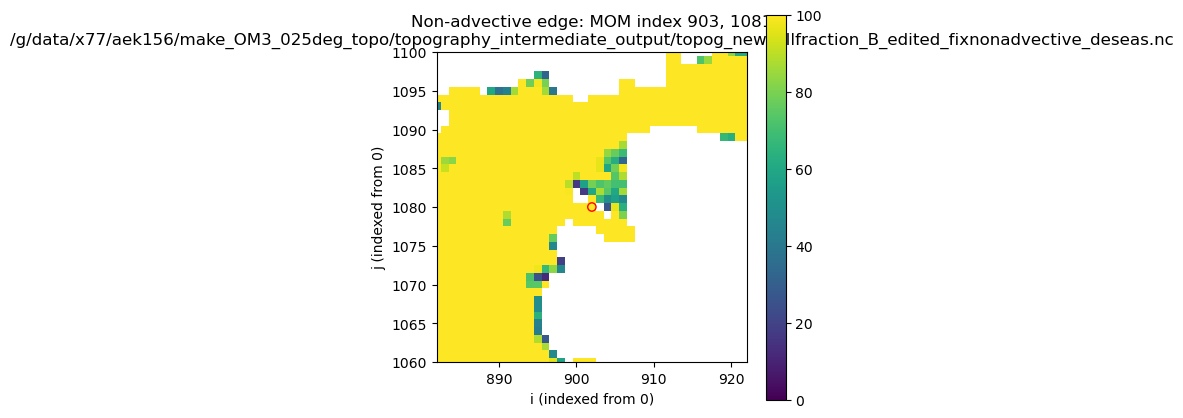

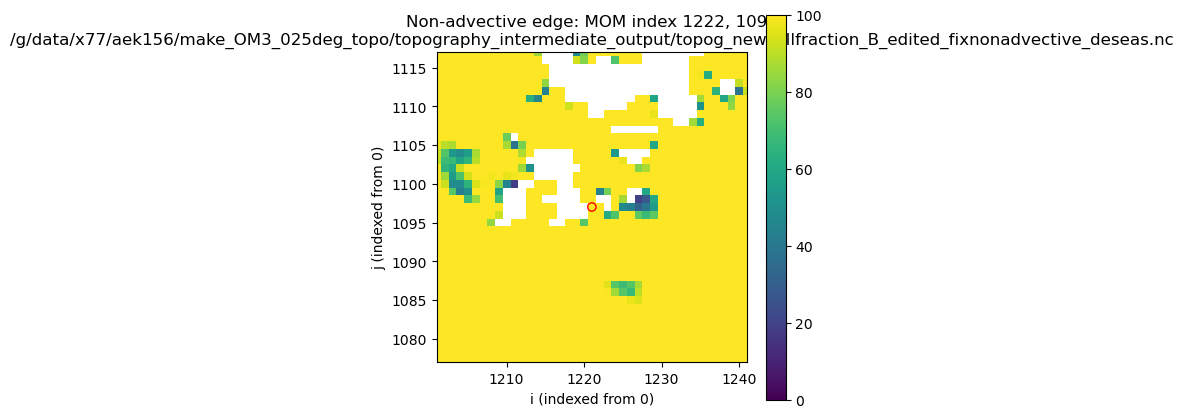

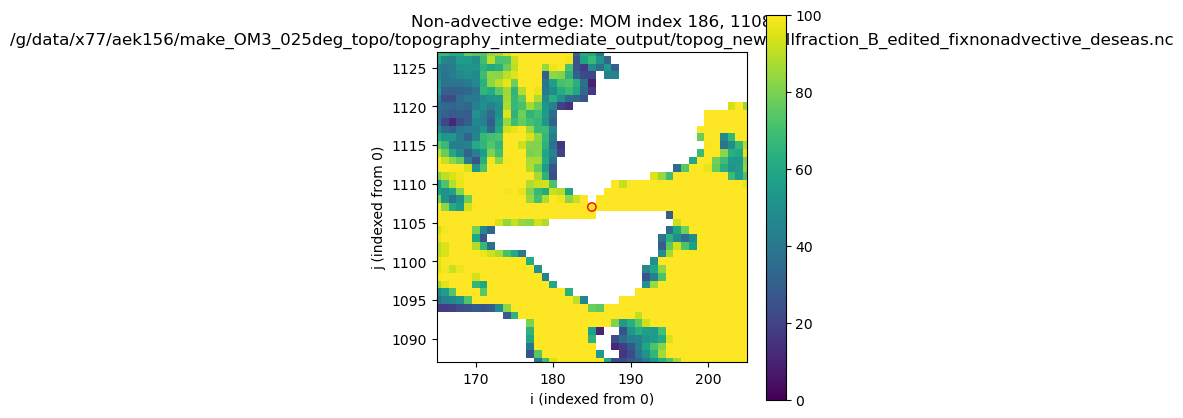

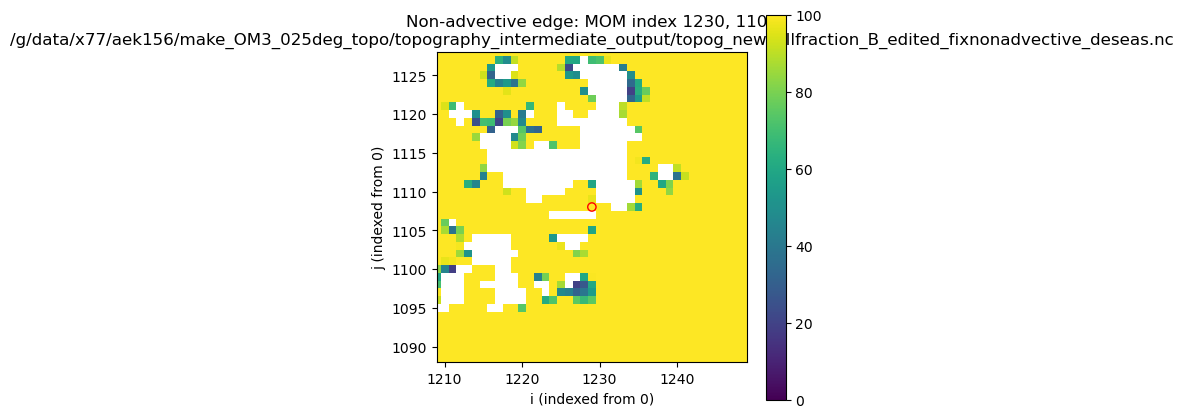

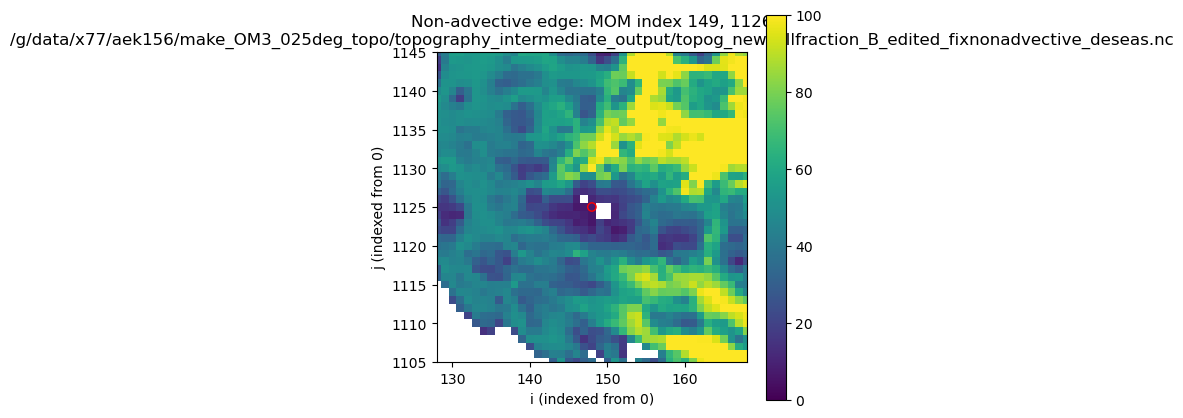

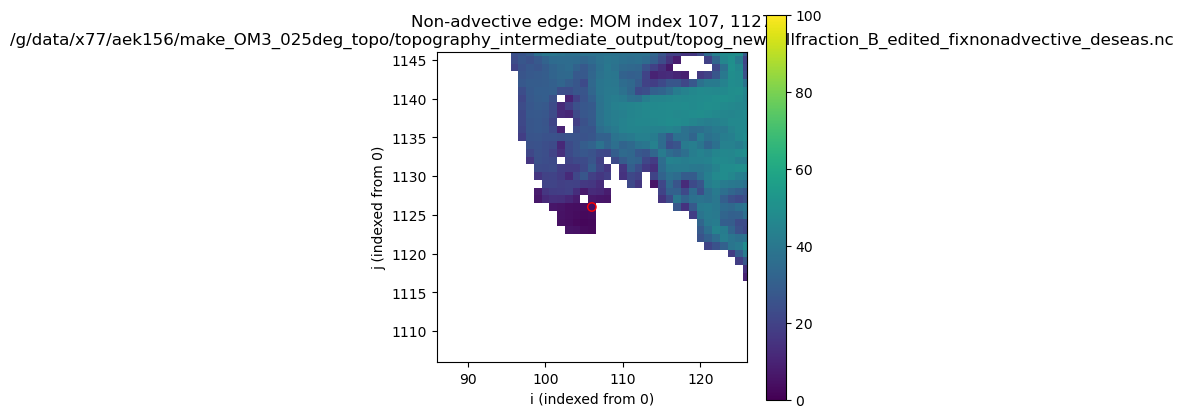

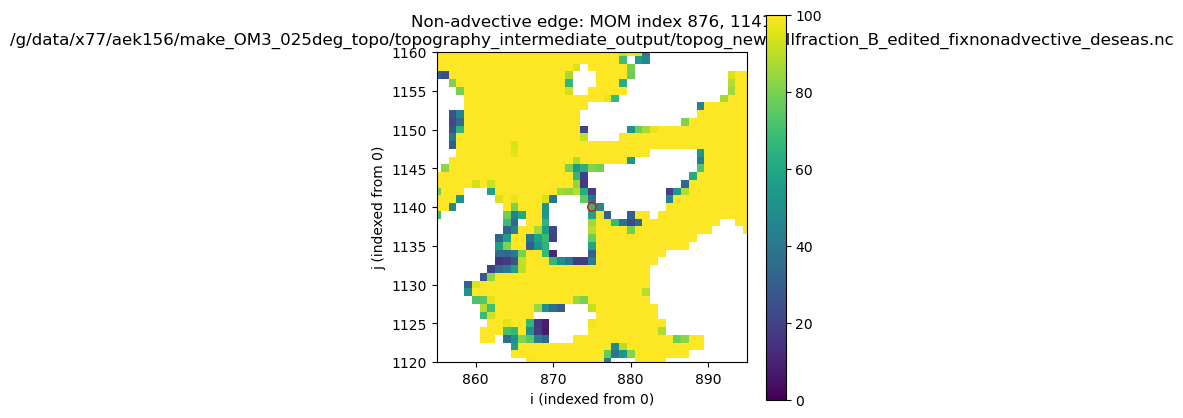

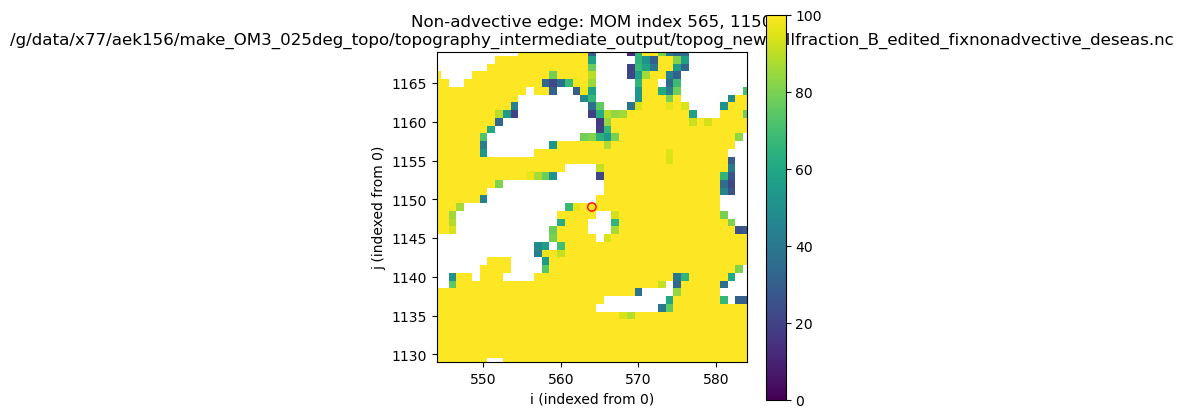

In [10]:
margin = 20
jj, ii=np.nonzero(noadv_edge)
print ('cells with a non-advective edge: '+repr(list(zip(ii+1, jj+1))))
for k in range(len(ii)):
    i = ii[k]
    j = jj[k]
    plt.figure(figsize=(5, 5))
    plt.imshow(depthtiled, vmin=0, vmax=100, origin='lower')
    plt.colorbar()
    plt.scatter(i, j, facecolors='none', edgecolors='r')
    plt.xlim(i-margin, i+margin)
    plt.ylim(j-margin, j+margin)
    plt.title('Non-advective edge: MOM index '+str(i+1)+', '+str(j+1)+'\n'+bathyfile)
    plt.xlabel('i (indexed from 0)')
    plt.ylabel('j (indexed from 0)')
    figfname = 'non-advective/non_advective_edge'+bathyfile.replace('/', '_').replace('.', '_')+'_'+str(i+1)+'_'+str(j+1)+'.png'
#     plt.savefig(figfname, dpi=100, bbox_inches="tight")

### Plot points that were changed by merging with B-grid version

1706

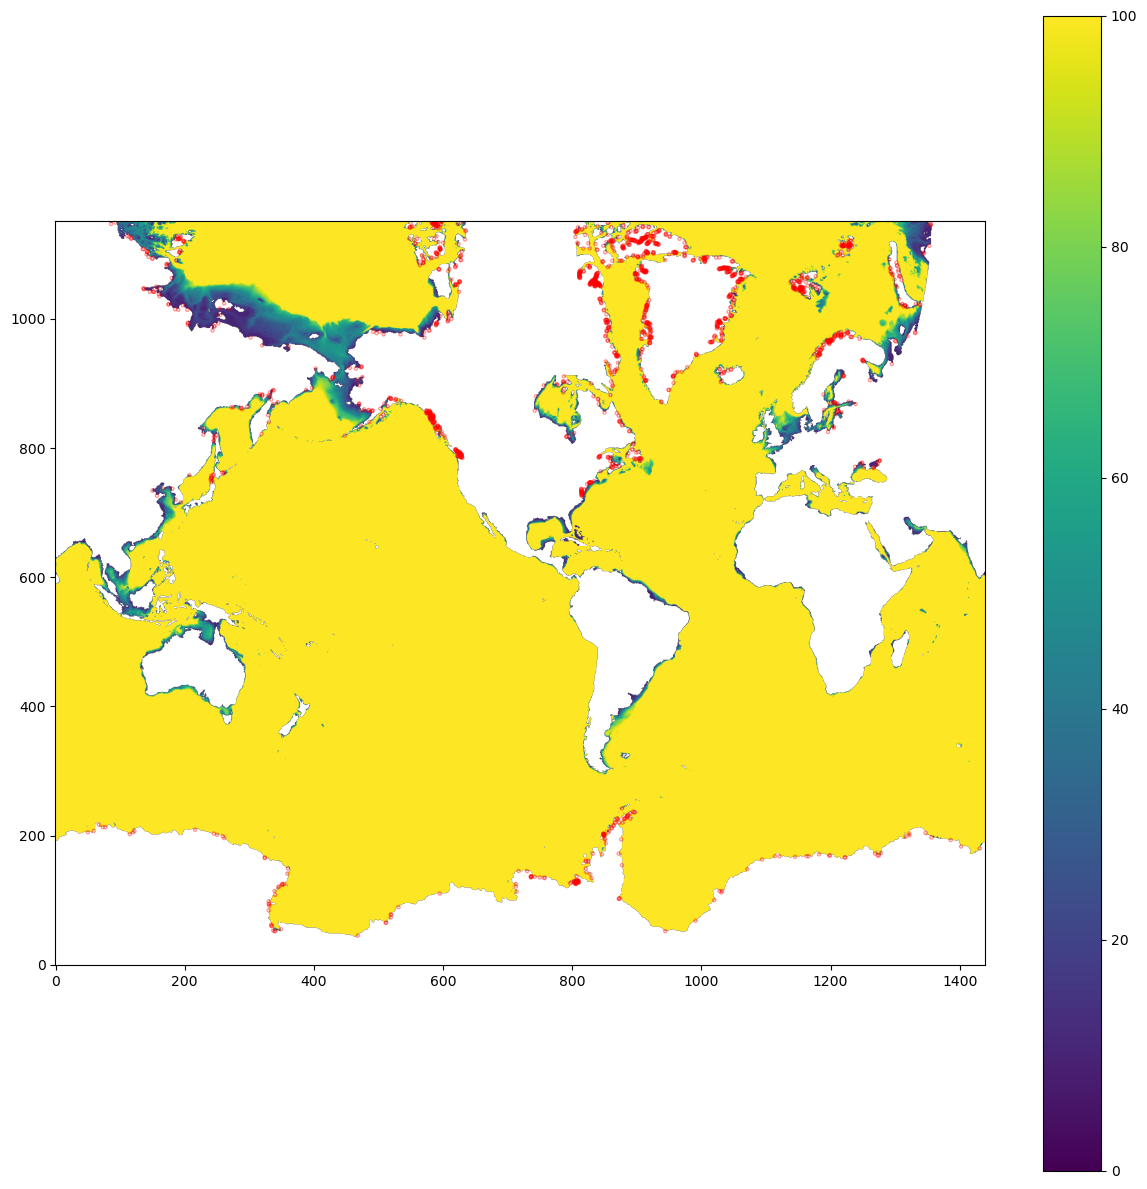

In [11]:
# C_depth = nc.Dataset(Cgrid).variables['depth'][:, :]
# merged_depth = nc.Dataset(merged).variables['depth'][:, :]

C_depth = nc.Dataset(Cgridfinal).variables['depth'][:, :]
merged_depth = nc.Dataset(final).variables['depth'][:, :]

diff = np.where(np.isnan(merged_depth), 0, merged_depth) - np.where(np.isnan(C_depth), 0, C_depth)

plt.figure(figsize=(15, 15))
plt.imshow(merged_depth, vmin=0, vmax=100, origin='lower')
plt.colorbar()
jj, ii = np.nonzero(diff)
plt.scatter(ii, jj, facecolors='none',
            edgecolors='r', alpha=0.4,
            s=5)
len(jj)

### Plot points that were changed by final edit (to confirm no B-grid non-advective cells have been created in ice-prone regions)

1

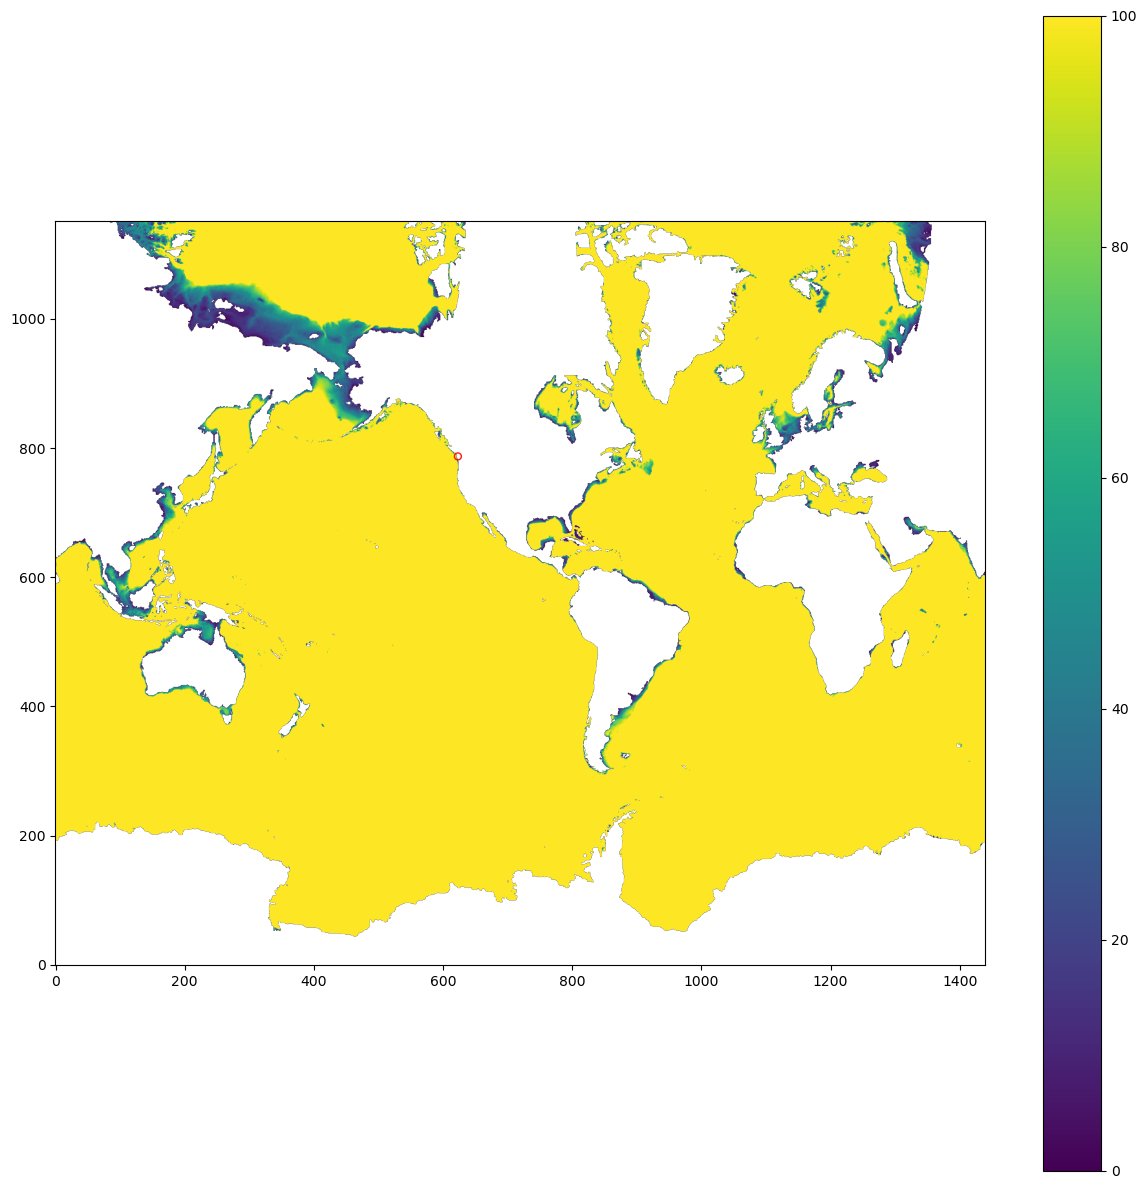

In [12]:
pre_edit_depth = nc.Dataset(merged).variables['depth'][:, :]
merged_post_edit_depth = nc.Dataset(merged_post_edit).variables['depth'][:, :]

diff = np.where(np.isnan(merged_post_edit_depth), 0, merged_post_edit_depth) - np.where(np.isnan(pre_edit_depth), 0, pre_edit_depth)

plt.figure(figsize=(15, 15))
plt.imshow(merged_post_edit_depth, vmin=0, vmax=100, origin='lower')
plt.colorbar()
jj, ii = np.nonzero(diff)
plt.scatter(ii, jj, facecolors='none',
            edgecolors='r', alpha=0.9,
            s=25)
len(jj)
# np.nonzero(diff)

#